# Parameter sweeps

Parameter sweeps for clustering statistics.

## Parameters for sweeps

Here we define the overall parameters that will be used for running the analysis. The parameters include a `LABEL` to name the experiments and output data, the path to actually save the output data, sampling rates, cutoffs, as well as any other simulation parameter.

In [1]:
LABEL          = 'sweeps-sampling-size'
RESULTS_PATH   = '../results'

SAMPLING_RATES = [k/100 for k in range(4, 102, 2)]  # [0.01, 0.2, 0.5, 0.7, 1.0]
CUTOFFS        = [k*365 for k in [2, 5, 7]]  # [1, 2.5, 5, 7.5, 10]]

REPS = 5  # Repeat simulations with different random number seeds for every set of parameters

## Initialization

Imports and other environment configuration.

In [2]:
import os
import itertools
import time
import warnings
import multiprocessing

import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

from find_clusters import run_analysis

In [3]:
# Create output directory and file name prefix
results_dir = os.path.join( os.path.abspath(RESULTS_PATH), LABEL )
if os.path.exists( results_dir ):
    print( '... the directory ', results_dir )
    print( '    already exists. Simulation results may overwrite files in' )
    print( '    this directory.' )
    if input( '    Do you want to continue? [y/N] ' ) != 'y':
        raise Exception('stopping execution')
else:
    os.makedirs( results_dir )

output_prefix = results_dir + '/' + LABEL

... the directory  /home/rnunez/work/clustersim/dev/20230720-with-phylomodels/results/sweeps-sampling-size
    already exists. Simulation results may overwrite files in
    this directory.


    Do you want to continue? [y/N]  y


## Load PANGEA-HIV clustering data

Let's get the data by reading this figure. We can use precise data (the one used for creating this figure) at a later time.
<!--- ![PANGEA-HIV Clustering Results](pangea_clustering.png) --->

<img src="pangea_clustering.png" alt="PANGEA-HIV Clustering Results" style="width: 800px;"/>

In [4]:
pangea_data = pd.DataFrame( [ [ 'HIVDRD, UK'         , 'firebrick' , 3.4 , 1.5 , 11   , 2   , 0.7 , 1.5    ],
                              [ 'PopART, Zambia'     , 'blue'      , 2.27, 0.29,  2.46, 0.39, 0.16, 3.19   ],
                              [ 'Rakai, Uganda'      , 'dodgerblue', 2.33, 0.30,  2.55, 0.36, 0.23, 3.27   ],
                              [ 'Ya Tsie, Botswana'  , 'teal'      , 2.07, 0.12,  2.10, 0.14, 0.02, 5.15   ],
                              [ 'ATHENA cohort (MSM)', 'orangered' , 4.58, 1.63, 16.78,	1.46, 0.33,	np.nan ],
                              [ 'ATHENA cohort (HET)', 'red'       , 2.67, 0.72,  4.04,	0.96, 0.19, np.nan ]
                             ],
                             columns = [ 'location',
                                         'color',
                                         'cluster size (mean)',
                                         'cluster size (CoV)',
                                         'weighted cluster size (mean)',
                                         'weighted cluster size (CoV)',
                                         'Gini coefficient', 
                                         'R0'
                                        ]
                           )

## Run branching process model

In [5]:
partner_number_sweep   = [ 0.35   ]  # [k/10    for k in range( 1,  9, 1)] # [ 0.25 , 0.5  , 0.75  ]
lambda_parameter_sweep = [ 0.001  ]  # [k/10000 for k in range( 5, 30, 5)] # [ 0.001, 0.002, 0.003 ]
acts_per_day_sweep     = [ 0.10   ]  # [k/100   for k in range(10, 40, 5)] # [ 0.10 , 0.20 , 0.30  ]
removal_rate_sweep     = [ 0.0005 ]  # [k/1000  for k in range( 1,  4, 1)] # [ 0.001, 0.002, 0.003 ]
sampling_delay_sweep   = [ 90, 120, 150, 180 ]
sample_size_sweep      = [ 100, 250, 500, 1000, 2000, 5000 ]

# Simulation defaults
SAMPLE_SIZE      = 250
SIM_TIME         = 365*20
RAND_SEED_OFFSET = 0

# Network defaults
MEAN_PARTNER = 0.35

# Transmission defaults          
ACTS_PER_DAY = 0.1
LAMBDA       = 0.001
REMOVAL_RATE = 0.0005

# Sampling defaults
SAMPLING_DELAY = 360


# Generate list of parameter sets
parameter_combinations = list( itertools.product( partner_number_sweep  ,
                                                  lambda_parameter_sweep,
                                                  acts_per_day_sweep,
                                                  removal_rate_sweep,
                                                  sampling_delay_sweep,
                                                  sample_size_sweep
                                                 )
                              )

In [6]:
def single_run( experiment_params={}, rand_seed_start=RAND_SEED_OFFSET ):

    # Prepare parameters for branching process simulation
    params = {}

    # Simulation configuration
    params['samplesize'] = experiment_params.get( 'samplesize', SAMPLE_SIZE      )
    params['sim_time'  ] = experiment_params.get( 'sim_time'  , SIM_TIME         )
    
    # Network
    params['mean_partner'] = experiment_params.get( 'mean_partner', MEAN_PARTNER )

    # Transmission          
    params['acts_per_day'] = experiment_params.get( 'acts_per_day', ACTS_PER_DAY )
    params['lambda'      ] = experiment_params.get( 'lambda'      , LAMBDA       )
    params['removal_rate'] = experiment_params.get( 'removal_rate', REMOVAL_RATE )

    # Sampling t
    params['sampling_delay'] = experiment_params.get( 'sampling_delay', SAMPLING_DELAY )


    # Run analysis
    output = pd.DataFrame()
    for rep in range(REPS):
        print( '... running rep ', 1+rep, '/', REPS )
        
        params['seed'] = rand_seed_start + rep
        this_output = run_analysis( SAMPLING_RATES, CUTOFFS, params, output_prefix )
        this_output['rep'] = rep

        output = pd.concat( [output, this_output], ignore_index=True )


    return output

Let's check the outputs of a 1D-sweep:

... running rep  1 / 5
  |==================================================| 100%
... running rep  2 / 5
  |==================================================| 100%
... running rep  3 / 5
  |==================================================| 100%
... running rep  4 / 5
  |==================================================| 100%
... running rep  5 / 5
  |==================================================| 100%


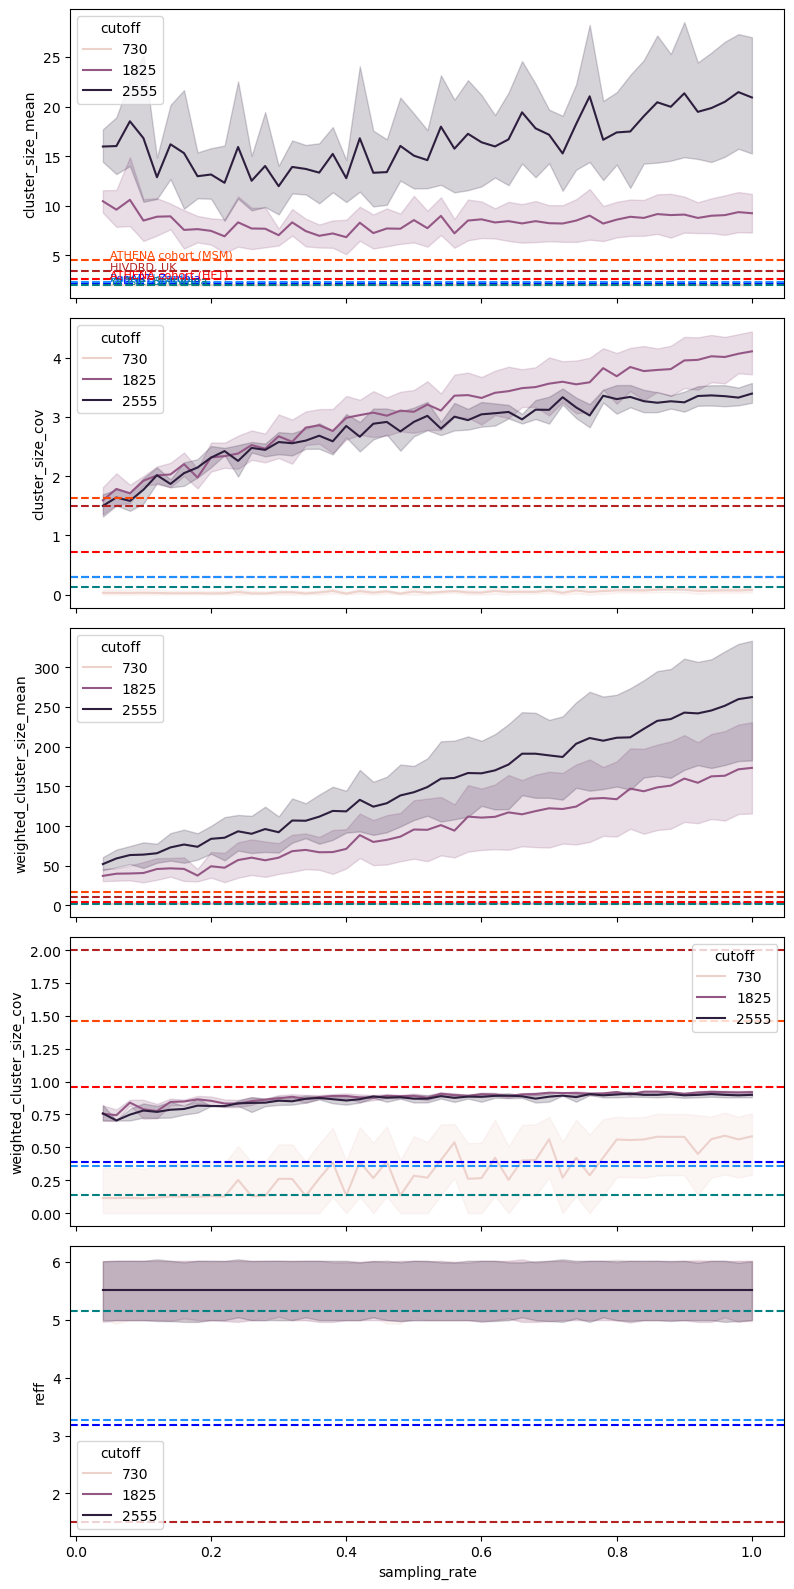

In [7]:
# Run parameter sweep 
out = single_run() \

# Plot clustering results
fig, axs = plt.subplots( 5, 1, figsize=(8,16), sharex=True )

seaborn.lineplot( data = out,
                  x    = 'sampling_rate',
                  y    = 'cluster_size_mean',
                  hue  = 'cutoff',
                  ax   = axs[0] 
                 )

seaborn.lineplot( data = out,
                  x    = 'sampling_rate',
                  y    = 'cluster_size_cov',
                  hue  = 'cutoff',
                  ax   = axs[1]
                 )

seaborn.lineplot( data = out,
                  x    = 'sampling_rate',
                  y    = 'weighted_cluster_size_mean',
                  hue  = 'cutoff',
                  ax   = axs[2] 
                 )

seaborn.lineplot( data = out,
                  x    = 'sampling_rate',
                  y    = 'weighted_cluster_size_cov',
                  hue  = 'cutoff',
                  ax   = axs[3]
                 )

seaborn.lineplot( data = out,
                  x    = 'sampling_rate',
                  y    = 'reff',
                  hue  = 'cutoff',
                  ax   = axs[4]
                 )


# Add observation data
for index, row in pangea_data.iterrows():
    axs[0].axhline( row['cluster size (mean)'], color=row['color'], linestyle='--' )
    axs[1].axhline( row['cluster size (CoV)' ], color=row['color'], linestyle='--' )
    axs[2].axhline( row['weighted cluster size (mean)'], color=row['color'], linestyle='--' )
    axs[3].axhline( row['weighted cluster size (CoV)' ], color=row['color'], linestyle='--' )
    axs[4].axhline( row['R0'], color=row['color'], linestyle='--' )

    axs[0].text(0.05, row['cluster size (mean)']*1.05, row['location'], color=row['color'], size=8 )

fig.tight_layout()

Now let's run the actual parameter sweep:

In [8]:
# This function runs an experiment and saves the results in a csv file
def run_experiment( partner_number, 
                    lambda_param, 
                    acts_per_day, 
                    removal_rate, 
                    sampling_delay,
                    samplesize,
                    experiment_id ):

    # Prepare parameters for branching process simulation
    experiment_params = {}

    # Simulation configuration
    experiment_params['samplesize'] = samplesize
    experiment_params['sim_time'  ] = SIM_TIME
    
    # Network
    experiment_params['mean_partner'] = partner_number

    # Transmission          
    experiment_params['acts_per_day'] = acts_per_day
    experiment_params['lambda'      ] = lambda_param
    experiment_params['removal_rate'] = removal_rate

    # Sampling t
    experiment_params['sampling_delay'] = sampling_delay

    print( '... Running experiment with experiment_params = ', experiment_params )


    # Run analysis and update results
    output = pd.DataFrame()
    tic = time.time()
    try:
        output = single_run( experiment_params )
    except:
        print('... error running experiment with experiment_params = ', experiment_params )
    toc = time.time() - tic
    for key, value in experiment_params.items():
        output[key] = value
    output['execution_time'] = toc
    output['experiment_id'] = experiment_id
    output.to_csv( output_prefix + '-parameter-sweep-results--experiment-' + str(experiment_id) + '.csv' )
    return

In [9]:
# And then run the actual simulations; we use a timeout because some simulations
# may get stuck when the epidemic does't take off
timeout = 2*1800        # in seconds
tasks   = parameter_combinations  # We parallelize based on sets of parameters
procs   = []          # This keeps track of the processes being executed
t0      = time.time()
n_processes = 14

count = 0
with warnings.catch_warnings(): # Avoiding a bunch of error messages
                                # when terminating a process
    warnings.simplefilter('ignore')
    while (len(tasks) > 0) or (len(procs) > 0):
        if (len(tasks) > 0) and (len(procs) < n_processes):  # Launch new processes
            experiment_params = tasks.pop(0)
            experiment_params = experiment_params + (count,)
            count = count + 1
            p = multiprocessing.Process( target=run_experiment, args=(experiment_params) )
            p.start()
            procs.append( { 'params':experiment_params, 'p':p, 't':time.time()+timeout } )
        
        for d in procs:  # Check if a process finished or timed out
            if not d['p'].is_alive():
                procs.remove(d)
                print( '\n... Analysis with parameters = ', d['params'], ' : DONE' )
                print( '   ', len(tasks), ' parameter sets remaining' )
            elif d['t'] < time.time():
                d['p'].terminate()
                procs.remove(d)
                print( '\n... Analysis with parameters = ', d['params'], ' : TIMEOUT' )
                print( '   ', len(tasks), ' parameter sets remaining' )
        time.sleep(0.05)
    
print( '... time spent running simulations = ', time.time()-t0, ' seconds' )

... Running experiment with experiment_params =  {'samplesize': 100, 'sim_time': 7300, 'mean_partner': 0.35, 'acts_per_day': 0.1, 'lambda': 0.001, 'removal_rate': 0.0005, 'sampling_delay': 90}
... running rep  1 / 5
  |                                                  |   1%... Running experiment with experiment_params =  {'samplesize': 250, 'sim_time': 7300, 'mean_partner': 0.35, 'acts_per_day': 0.1, 'lambda': 0.001, 'removal_rate': 0.0005, 'sampling_delay': 90}
  |=                                                 |   1% 5
  |=                                                 |   2%... Running experiment with experiment_params =  {'samplesize': 500, 'sim_time': 7300, 'mean_partner': 0.35, 'acts_per_day': 0.1, 'lambda': 0.001, 'removal_rate': 0.0005, 'sampling_delay': 90}
... running rep  1 / 5
  |==                                                |   4%... Running experiment with experiment_params =  {'samplesize': 1000, 'sim_time': 7300, 'mean_partner': 0.35, 'acts_per_day': 0.1, 'lamb